# Data-Driven Strategies: Optimizing Lyft Driver Performance

## Table Of Contents

* [Business Problem Statement](#business-problem-statement)
* [Data Description](#data-description)
* [Exploratory Data Analysis](#exploratory-data-analysis)
* [Data Engineering](#data-engineering)
* [Main Factors Affecting a Driver's Lifetime Value](#main-factors-affecting-a-driver's=lifetime-value)
* [Average Projected Lifetime of a Driver](#average-projected-lifetime-of-a-driver)
* [Do All Drivers Act Alike?](#do-all-drivers-act-alike?)
* [Actionable Recommendations](#actionable-recommendations)



<a name="business-problem-statement"></a>
# Business Problem Statement:

Seeking insights into user behavior and preferences related to accommodation searches and host acceptance criteria. The goal is to enhance the overall supply-demand equilibrium on the platform. The challenge involves a thorough analysis, interpretation, and visualization of market dynamics. Exploring factors such as preferred start dates, duration of stays, and room types in relation to host acceptance rates is crucial. The primary focus is on identifying gaps between user demand and host supply, providing actionable insights to optimize the platform's performance. The challenge also aims to identify additional datasets that could enhance the analysis and provide a more comprehensive understanding of market trends.

![Image](https://venturebeat.com/wp-content/uploads/2018/05/lyft-amp-illo-1200x630-e1571886000931.png?fit=750%2C375&strip=all)

<a name="data-description"></a>
# Data Description:

In the searches dataset:

**ds:** Date of the search
**id_user:** Alphanumeric user_id
**ds_checkin:** Date stamp of the check-in date of the search
**ds_checkout:** Date stamp of the check-out date of the search
**n_searches:** Number of searches in the search set
**n_nights:** The number of nights the search was for
**n_guests_min:** The minimum number of guests selected in a search set
**n_guests_max:** The maximum number of guests selected in a search set
**origin_country:** The country the search was from
**filter_price_min:** The value of the lower bound of the price filter, if the user used it
**filter_price_max:** The value of the upper bound of the price filter, if the user used it
**filter_room_types:** The room types that the user filtered by, if the user used the room_types filter
**filter_neighborhoods:** The neighborhood types that the user filtered by, if the user used the neighborhoods filter
In the contacts dataset:

**id_guest:** Alphanumeric user_id of the guest making the inquiry
**id_host:** Alphanumeric user_id of the host of the listing to which the inquiry is made
**id_listing:** Alphanumeric identifier for the listing to which the inquiry is made
**ts_contact_at:** UTC timestamp of the moment the inquiry is made.
**ts_reply_at:** UTC timestamp of the moment the host replies to the inquiry, if so
**ts_accepted_at:** UTC timestamp of the moment the host accepts the inquiry, if so
**ts_booking_at:** UTC timestamp of the moment the booking is made, if so
**ds_checkin:** Date stamp of the check-in date of the inquiry
**ds_checkout:** Date stamp of the check-out date of the inquiry
**n_guests:** The number of guests the inquiry is for
**n_messages:** The total number of messages that were sent around this inquiry

<a name="exploratory-data-analysis"></a>
# Exploratory Data Analysis:


In the exploratory data analysis (EDA) process, we begin by importing essential libraries for data manipulation and visualization, including pandas for data manipulation, numpy for numerical operations, and matplotlib.pyplot and seaborn for data visualization. Following this, we read three datasets into pandas DataFrames: driver_ids.csv, ride_timestamps.csv, and ride_ids.csv. These datasets likely contain information related to drivers, ride timestamps, and ride IDs, respectively. Unfortunately, the code snippet provided does not display a sample of the driver_ids dataset, which is typically an initial step in EDA to gain insights into the structure and content of the data. Further exploration and analysis would involve examining the first few rows, data types, and summary statistics of the datasets, identifying missing values, and visualizing distributions or relationships among variables to uncover patterns and trends in the data.

In [68]:
# Import the required libraries
import pandas as pd  # for data manipulation and analysis
import numpy as np  # for numerical operations
import matplotlib.pyplot as plt  # for data visualization
import seaborn as sns  # for advanced data visualization

# Read all datasets
driver_data = pd.read_csv('driver_ids.csv')
ride_timestamp_data = pd.read_csv('ride_timestamps.csv')
ride_data = pd.read_csv('ide_ids.csv')

<a name="data-engineering"></a>
# Data Engineering

## Calculate the Total Cost of Ride

Calculating the total cost of a ride (representing the driver's lifetime value) based on constant variables. These constants include the base fare (BASE_FARE), cost per mile (COST_PER_MILE), cost per minute (COST_PER_MIN), service fee (SERVICE_FEE), minimum fare (MIN_FARE), and maximum fare (MAX_FARE). The formula incorporates the ride duration, ride distance, and service fee, applying both lower and upper bounds to ensure the calculated total ride cost falls within a specified range. Finally, the first three rows of the resulting DataFrame, ride_data, are printed to provide an initial glimpse of the calculated values. This process aids in understanding how the lifetime value of a ride is computed and ensures that the derived cost is within predefined limits.

In [69]:
# Constant variables used to calculate total cost of ride (driver's lifetime value)
BASE_FARE = 2.00
COST_PER_MILE = 1.15
COST_PER_MIN = 0.22
SERVICE_FEE = 1.75
MIN_FARE = 5.00
MAX_FARE = 400.00

# Calculate total lifetime of ride
ride_data['total_ride_cost'] = (
    (BASE_FARE + (COST_PER_MIN * (ride_data['ride_duration'] / 60)) + (COST_PER_MILE * (ride_data['ride_distance'] / 1609.34))) +
    SERVICE_FEE
)

# Apply lower and upper bound to ride cost
ride_data['total_ride_cost'] = np.where(ride_data['total_ride_cost'] < MIN_FARE, MIN_FARE, ride_data['total_ride_cost'])
ride_data['total_ride_cost'] = np.where(ride_data['total_ride_cost'] > MAX_FARE, MAX_FARE, ride_data['total_ride_cost'])

# Print first 3 rows in DataFrame
print(ride_data.head(3))

                          driver_id                           ride_id  \
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   

   ride_distance  ride_duration  ride_prime_time  total_ride_cost  
0           1811            327               50         6.243102  
1           3362            809                0         9.118747  
2           3282            572                0         8.192580  


## Create Features of the Rides

 Pivoting ride events from the ride_timestamp_data DataFrame. It creates a new DataFrame named ride_events using the pivot function. The index is set as the 'ride_id', the columns are derived from the 'event' column, and the values are extracted from the 'timestamp' column. The resulting DataFrame is then printed to display the first three rows, providing a structured view of the pivoted ride events for further analysis. This operation is useful for organizing and summarizing the timestamp data in a more interpretable format.

In [70]:
# Pivot the ride events
ride_events = ride_timestamp_data.pivot(index='ride_id', columns='event', values='timestamp')
print(ride_events.head(3))


event                                     accepted_at           arrived_at  \
ride_id                                                                      
00003037a262d9ee40e61b5c0718f7f0  2016-06-13 09:39:51  2016-06-13 09:44:31   
00005eae40882760d675da5effb89ae3  2016-05-14 05:23:25  2016-05-14 05:26:17   
000061d42cf29f73b591041d9a1b2973  2016-05-16 15:43:14  2016-05-16 15:47:29   

event                                  dropped_off_at         picked_up_at  \
ride_id                                                                      
00003037a262d9ee40e61b5c0718f7f0  2016-06-13 10:03:05  2016-06-13 09:44:33   
00005eae40882760d675da5effb89ae3  2016-05-14 05:34:17  2016-05-14 05:26:18   
000061d42cf29f73b591041d9a1b2973  2016-05-16 15:54:18  2016-05-16 15:47:32   

event                                    requested_at  
ride_id                                                
00003037a262d9ee40e61b5c0718f7f0  2016-06-13 09:39:19  
00005eae40882760d675da5effb89ae3  2016-05-14 05:23

Merges the ride_data DataFrame with the previously created ride_events DataFrame based on the common column 'ride_id'. The resulting merged DataFrame is named merged_ride_data. The shape of the merged DataFrame is then printed for reference, and the first three rows of the merged data are displayed using the head function. This operation combines information from both datasets, allowing for a more comprehensive analysis of ride-related events in a consolidated form.

In [71]:
# Merge ride_data with ride events on ride_id
merged_ride_data = pd.merge(ride_data, ride_events, on='ride_id')
print('Shape of Merged Ride Data:', merged_ride_data.shape)
print(merged_ride_data.head(3))

Shape of Merged Ride Data: (184819, 11)
                          driver_id                           ride_id  \
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   

   ride_distance  ride_duration  ride_prime_time  total_ride_cost  \
0           1811            327               50         6.243102   
1           3362            809                0         9.118747   
2           3282            572                0         8.192580   

           accepted_at           arrived_at       dropped_off_at  \
0  2016-04-23 02:14:15  2016-04-23 02:16:36  2016-04-23 02:22:07   
1  2016-03-29 19:00:52  2016-03-29 19:03:57  2016-03-29 19:17:30   
2  2016-06-21 11:56:39  2016-06-21 12:01:32  2016-06-21 12:11:07   

          picked_up_at         requested_at  
0  2016-04-23 02:16:40  2016-04-23 02:13:50  
1  2016-03-29 19:04:01  2

Involving additional feature engineering on the merged_ride_data DataFrame. It converts ride distance from meters to kilometers (distance_km) and ride duration from seconds to minutes (duration_min). Several new features are created, including:

**accept_response_time_min**: The time a driver takes to accept a ride once it is requested in minutes.

**arrival_time_min**: The time a driver takes to reach the pickup location once a ride is accepted in minutes.

**wait_time_min**: The time a driver waits for the rider once the driver reaches the pickup location in minutes.

Furthermore, the ride distance is divided into three categories (Short, Medium, Long) based on percentiles (ride_length_category), and the ride time is divided into three categories (Morning, Evening, Night) based on the hour of the day (ride_time_category). The ride_date feature is created by converting the accepted_at column to date format. The first three rows of the updated DataFrame are printed for inspection.

In [72]:

# Convert ride distance from meters to kilometers
merged_ride_data["distance_km"] = merged_ride_data["ride_distance"] / 1000
# Convert ride duration from seconds to minutes
merged_ride_data["duration_min"] = merged_ride_data["ride_duration"] / 60

# Create some features
merged_ride_data['accept_response_time_min'] = (pd.to_datetime(merged_ride_data['accepted_at']) - pd.to_datetime(merged_ride_data['requested_at'])).dt.total_seconds() / 60
merged_ride_data['arrival_time_min'] = (pd.to_datetime(merged_ride_data['arrived_at']) - pd.to_datetime(merged_ride_data['accepted_at'])).dt.total_seconds() / 60
merged_ride_data['wait_time_min'] = (pd.to_datetime(merged_ride_data['picked_up_at']) - pd.to_datetime(merged_ride_data['arrived_at'])).dt.total_seconds() / 60

# Divide ride distance into 3 categories (Short, Medium, Long) dependent on ride_distance
merged_ride_data["ride_length_category"] = pd.qcut(merged_ride_data["distance_km"], q=[0, 0.33, 0.66, 1], labels=['Short', 'Medium', 'Long'])
# Divide ride time into 3 categories (Morning, Evening, Night) dependent on accepted_at time
merged_ride_data["ride_time_category"] = pd.cut(pd.to_datetime(merged_ride_data['accepted_at']).dt.hour,
                                                 bins=[-1, 6, 18, 24], labels=['Night', 'Morning', 'Evening'])

# Convert accepted_at column to date
merged_ride_data['ride_date'] = pd.to_datetime(merged_ride_data['accepted_at']).dt.date

# Print first 3 rows in ride data
print(merged_ride_data.head(3))

                          driver_id                           ride_id  \
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   

   ride_distance  ride_duration  ride_prime_time  total_ride_cost  \
0           1811            327               50         6.243102   
1           3362            809                0         9.118747   
2           3282            572                0         8.192580   

           accepted_at           arrived_at       dropped_off_at  \
0  2016-04-23 02:14:15  2016-04-23 02:16:36  2016-04-23 02:22:07   
1  2016-03-29 19:00:52  2016-03-29 19:03:57  2016-03-29 19:17:30   
2  2016-06-21 11:56:39  2016-06-21 12:01:32  2016-06-21 12:11:07   

          picked_up_at         requested_at  distance_km  duration_min  \
0  2016-04-23 02:16:40  2016-04-23 02:13:50        1.811      5.450000   
1  2016-0

Generating a histogram to visualize the distribution of ride length categories (ride_length_category) in the merged_ride_data DataFrame. The seaborn library is used for plotting, and the resulting histogram provides insights into the frequency of short, medium, and long rides. The plt.show() function is utilized to display the plot.

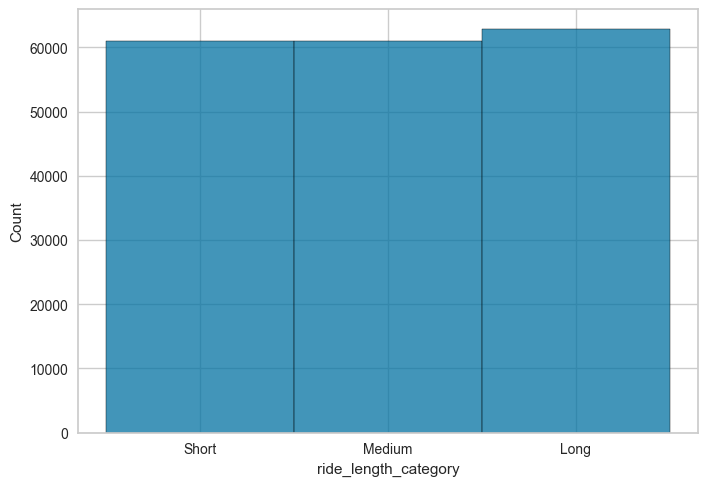

In [73]:

# Histogram of ride length categories
sns.histplot(merged_ride_data["ride_length_category"])
plt.show()

## Create Features of the Drivers

 Calculating the daily ride count for each driver and creates a pivot table named driver_perday_ridecount with the count of rides for each day. This information is obtained from the merged_ride_data DataFrame, and the resulting pivot table provides a snapshot of how many rides each driver has completed on each day. The print(driver_perday_ridecount.head(3)) line displays the first three rows of the pivot table for initial examination.

In [74]:

# Calculate driver_perday_ridecount
driver_perday_ridecount = merged_ride_data.pivot_table(index='driver_id', columns='ride_date', aggfunc='size')
print(driver_perday_ridecount.head(3))

ride_date                         2016-03-28  2016-03-29  2016-03-30  \
driver_id                                                              
002be0ffdc997bd5c50703158b7c2491         NaN         6.0         NaN   
007f0389f9c7b03ef97098422f902e62         NaN         1.0         NaN   
011e5c5dfc5c2c92501b8b24d47509bc         NaN         NaN         NaN   

ride_date                         2016-03-31  2016-04-01  2016-04-02  \
driver_id                                                              
002be0ffdc997bd5c50703158b7c2491         8.0         7.0         5.0   
007f0389f9c7b03ef97098422f902e62         NaN         NaN         NaN   
011e5c5dfc5c2c92501b8b24d47509bc         NaN         NaN         NaN   

ride_date                         2016-04-03  2016-04-04  2016-04-05  \
driver_id                                                              
002be0ffdc997bd5c50703158b7c2491         NaN         NaN         7.0   
007f0389f9c7b03ef97098422f902e62         NaN         NaN      

Creating a summary DataFrame named driver_summary containing various metrics and statistics for each driver based on their ride data. The summary includes total ride count (total_rides), total ride distance in kilometers (total_distance_km), total ride duration in minutes (total_duration_min), lifetime value (total revenue, lifetime_value), mean daily ride count (rides_per_day_mean), mean ride accept response time in minutes (accept_response_time_mean_min), mean ride arrival time in minutes (arrival_time_mean_min), and mean ride wait time in minutes (wait_time_mean_min).

Additionally, the code counts the total number of rides in different categories based on ride length (ride_length_category) and ride time (ride_time_category). The resulting driver_summary DataFrame provides a comprehensive overview of each driver's performance and behavior in the ride-sharing platform. The print(driver_summary.head(5)) line displays the first five rows of the summarized data for initial inspection.

In [75]:

driver_summary = pd.DataFrame()
# Calculate driver total ride count
driver_summary['total_rides'] = merged_ride_data.pivot_table(index=['driver_id'], aggfunc='size')
# Calculate driver total ride distance
driver_summary['total_distance_km'] = ride_data.groupby('driver_id')['ride_distance'].sum()
# Calculate driver total ride duration
driver_summary['total_duration_min'] = ride_data.groupby('driver_id')['ride_duration'].sum()
# Calculate driver lifetime value (total revenue)
driver_summary['lifetime_value'] = ride_data.groupby('driver_id')['total_ride_cost'].sum()
# Calculate mean driver count ride per day
driver_summary['rides_per_day_mean'] = driver_perday_ridecount.mean(axis=1)
# Calculate mean of ride accept response time for every driver
driver_summary['accept_response_time_mean_min'] = (merged_ride_data.groupby(merged_ride_data['driver_id']).aggregate(
    {'accept_response_time_min': 'mean'})).reset_index()['accept_response_time_min']
# Calculate mean of ride arrival time for every driver
driver_summary['arrival_time_mean_min'] = (merged_ride_data.groupby(merged_ride_data['driver_id']).aggregate(
    {'arrival_time_min': 'mean'})).reset_index()['arrival_time_min']
# Calculate mean of ride wait time for every driver
driver_summary['wait_time_mean_min'] = (merged_ride_data.groupby(merged_ride_data['driver_id']).aggregate(
    {'wait_time_min': 'mean'})).reset_index()['wait_time_min']

# Count total no. of short/medium/long evening rides
driver_summary = pd.merge(driver_summary,
                          merged_ride_data.pivot_table(index='driver_id', columns='ride_length_category',
                                                     aggfunc='size', fill_value=0).reset_index(),
                          on='driver_id')

# Count total no. of day/night/evening rides
driver_summary = pd.merge(driver_summary,
                          merged_ride_data.pivot_table(index='driver_id', columns='ride_time_category',
                                                     aggfunc='size', fill_value=0).reset_index(),
                          on='driver_id')

# Fill nan values with 0
driver_summary = driver_summary.fillna(0).reset_index()
print(driver_summary.head(5))

   index                         driver_id  total_rides  total_distance_km  \
0      0  002be0ffdc997bd5c50703158b7c2491          277            1740287   
1      1  007f0389f9c7b03ef97098422f902e62           31             117531   
2      2  011e5c5dfc5c2c92501b8b24d47509bc           34             269653   
3      3  0152a2f305e71d26cc964f8d4411add9          191            1471239   
4      4  01674381af7edd264113d4e6ed55ecda          375            3123644   

   total_duration_min  lifetime_value  rides_per_day_mean  \
0              221238     3094.039917            4.946429   
1               20497      275.486554            2.583333   
2               29205      427.273276            2.833333   
3              174521     2409.446265            4.775000   
4              357443     4949.088065            9.375000   

   accept_response_time_mean_min  arrival_time_mean_min  wait_time_mean_min  \
0                            0.0                    0.0                 0.0   
1     

 Calculating the duration of how long drivers typically continue driving with Lyft. It starts by merging the merged_ride_data DataFrame with the driver_data DataFrame using the 'driver_id' as the common key. The resulting onboard_data DataFrame contains information about the maximum accepted timestamp for each driver and the corresponding driver onboard date.

Then, it calculates the driver_duration_days, which represents the length of time in days between the accepted timestamp and the driver onboard date. The formula divides the total seconds between these two dates by the number of seconds in a day.

Finally, the code prints the onboard_data DataFrame, which includes the 'driver_id' and 'driver_duration_days' columns, showing how long each driver has typically continued driving with Lyft in days.

In [76]:
# Calculate how long do the drivers typically continue driving with Lyft
onboard_data = pd.merge(merged_ride_data.groupby('driver_id').agg({'accepted_at': max}), driver_data, on='driver_id')
# Calculate driver_duration, the length of how long a driver continues driving with Lyft per days
onboard_data['driver_duration_days'] = (
        (pd.to_datetime(onboard_data['accepted_at']) - pd.to_datetime(onboard_data['driver_onboard_date'])).dt.total_seconds() /
        (60 * 60 * 24)
)
onboard_data = onboard_data[['driver_id', 'driver_duration_days']]
print(onboard_data)

                            driver_id  driver_duration_days
0    002be0ffdc997bd5c50703158b7c2491             86.421181
1    007f0389f9c7b03ef97098422f902e62             85.553981
2    011e5c5dfc5c2c92501b8b24d47509bc             68.848924
3    0152a2f305e71d26cc964f8d4411add9             64.428229
4    01674381af7edd264113d4e6ed55ecda             56.544236
..                                ...                   ...
832  ff419a3476e21e269e340b5f1f05414e             61.748866
833  ff714a67ba8c6a108261cd81e3b77f3a             81.388241
834  fff482c704d36a1afe8b8978d5486283             34.672755
835  fffecccc49436c5389075b13209f0dfa             51.872095
836  ffff51a71f2f185ec5e97d59dbcd7a78             53.996447

[837 rows x 2 columns]


 Merging the driver_summary DataFrame with the onboard_data DataFrame using the 'driver_id' as the common key. The resulting DataFrame is updated with the additional information about how long each driver typically continues driving with Lyft in days. The printed output shows the merged DataFrame, providing a comprehensive summary of various metrics related to driver activity and engagement with Lyft.

In [77]:


driver_summary = pd.merge(driver_summary, onboard_data, on='driver_id')
print(driver_summary)

     index                         driver_id  total_rides  total_distance_km  \
0        0  002be0ffdc997bd5c50703158b7c2491          277            1740287   
1        1  007f0389f9c7b03ef97098422f902e62           31             117531   
2        2  011e5c5dfc5c2c92501b8b24d47509bc           34             269653   
3        3  0152a2f305e71d26cc964f8d4411add9          191            1471239   
4        4  01674381af7edd264113d4e6ed55ecda          375            3123644   
..     ...                               ...          ...                ...   
832    839  ff419a3476e21e269e340b5f1f05414e          242            2002400   
833    840  ff714a67ba8c6a108261cd81e3b77f3a          485            2834765   
834    841  fff482c704d36a1afe8b8978d5486283           35             174394   
835    842  fffecccc49436c5389075b13209f0dfa          406            2924913   
836    843  ffff51a71f2f185ec5e97d59dbcd7a78          330            2372018   

     total_duration_min  lifetime_value

Generates histograms for various metrics within the driver_summary DataFrame, presenting a visual representation of the distribution of data. Each histogram corresponds to different attributes such as total rides, total ride distance, total ride duration, lifetime value, rides per day mean, accept response time mean, arrival time mean, wait time mean, and the duration of how long a driver continues driving with Lyft in days. The histograms help visualize the spread and distribution of these metrics, providing insights into the patterns and characteristics of Lyft driver activity.

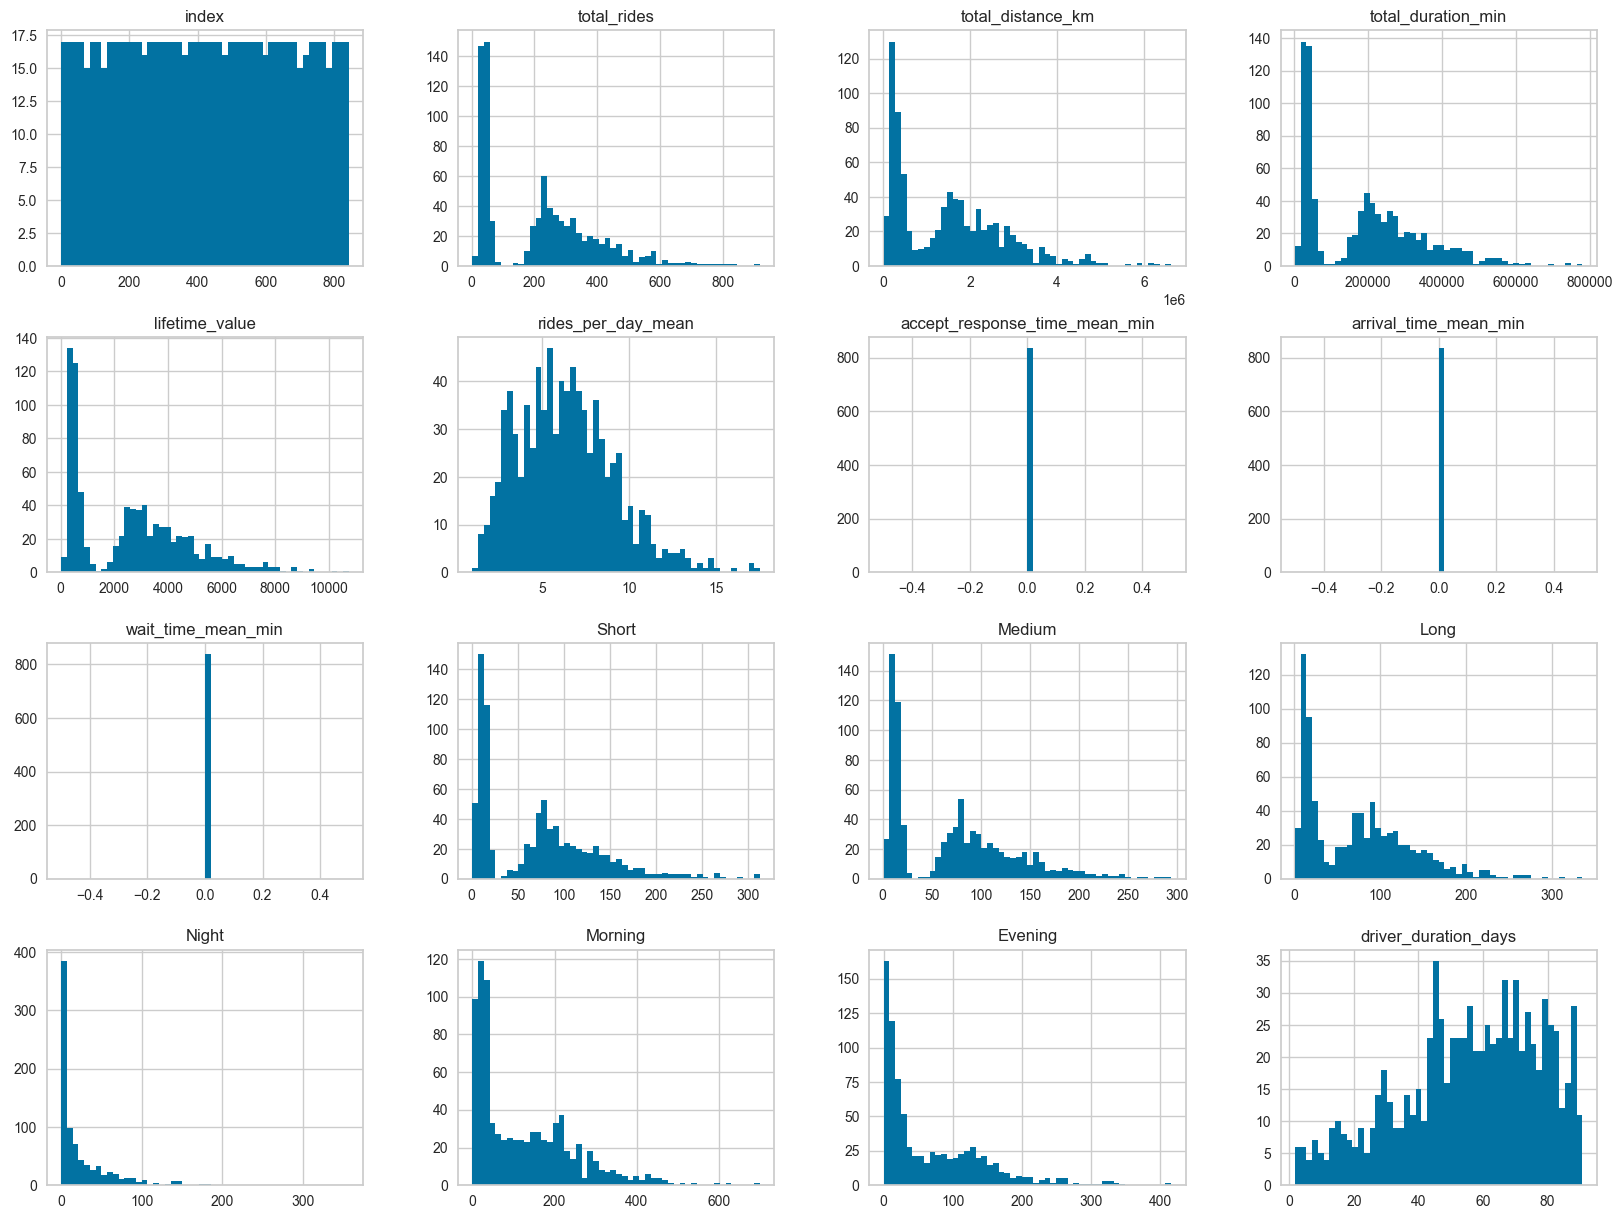

In [78]:
# Plot histograms of data
driver_summary.hist(bins=50, figsize=(20, 15))
plt.show()

Creating scatter plots for various pairs of attributes within the driver_summary DataFrame. Each point on the scatter plot represents a driver, and the position of the point is determined by the values of two different attributes. This visualization allows for the examination of relationships and patterns between different features, helping to identify potential correlations or trends in the data. The pairplot provides a comprehensive overview of the interactions between the selected attributes, aiding in the understanding of the underlying structure and dependencies in the Lyft driver dataset.

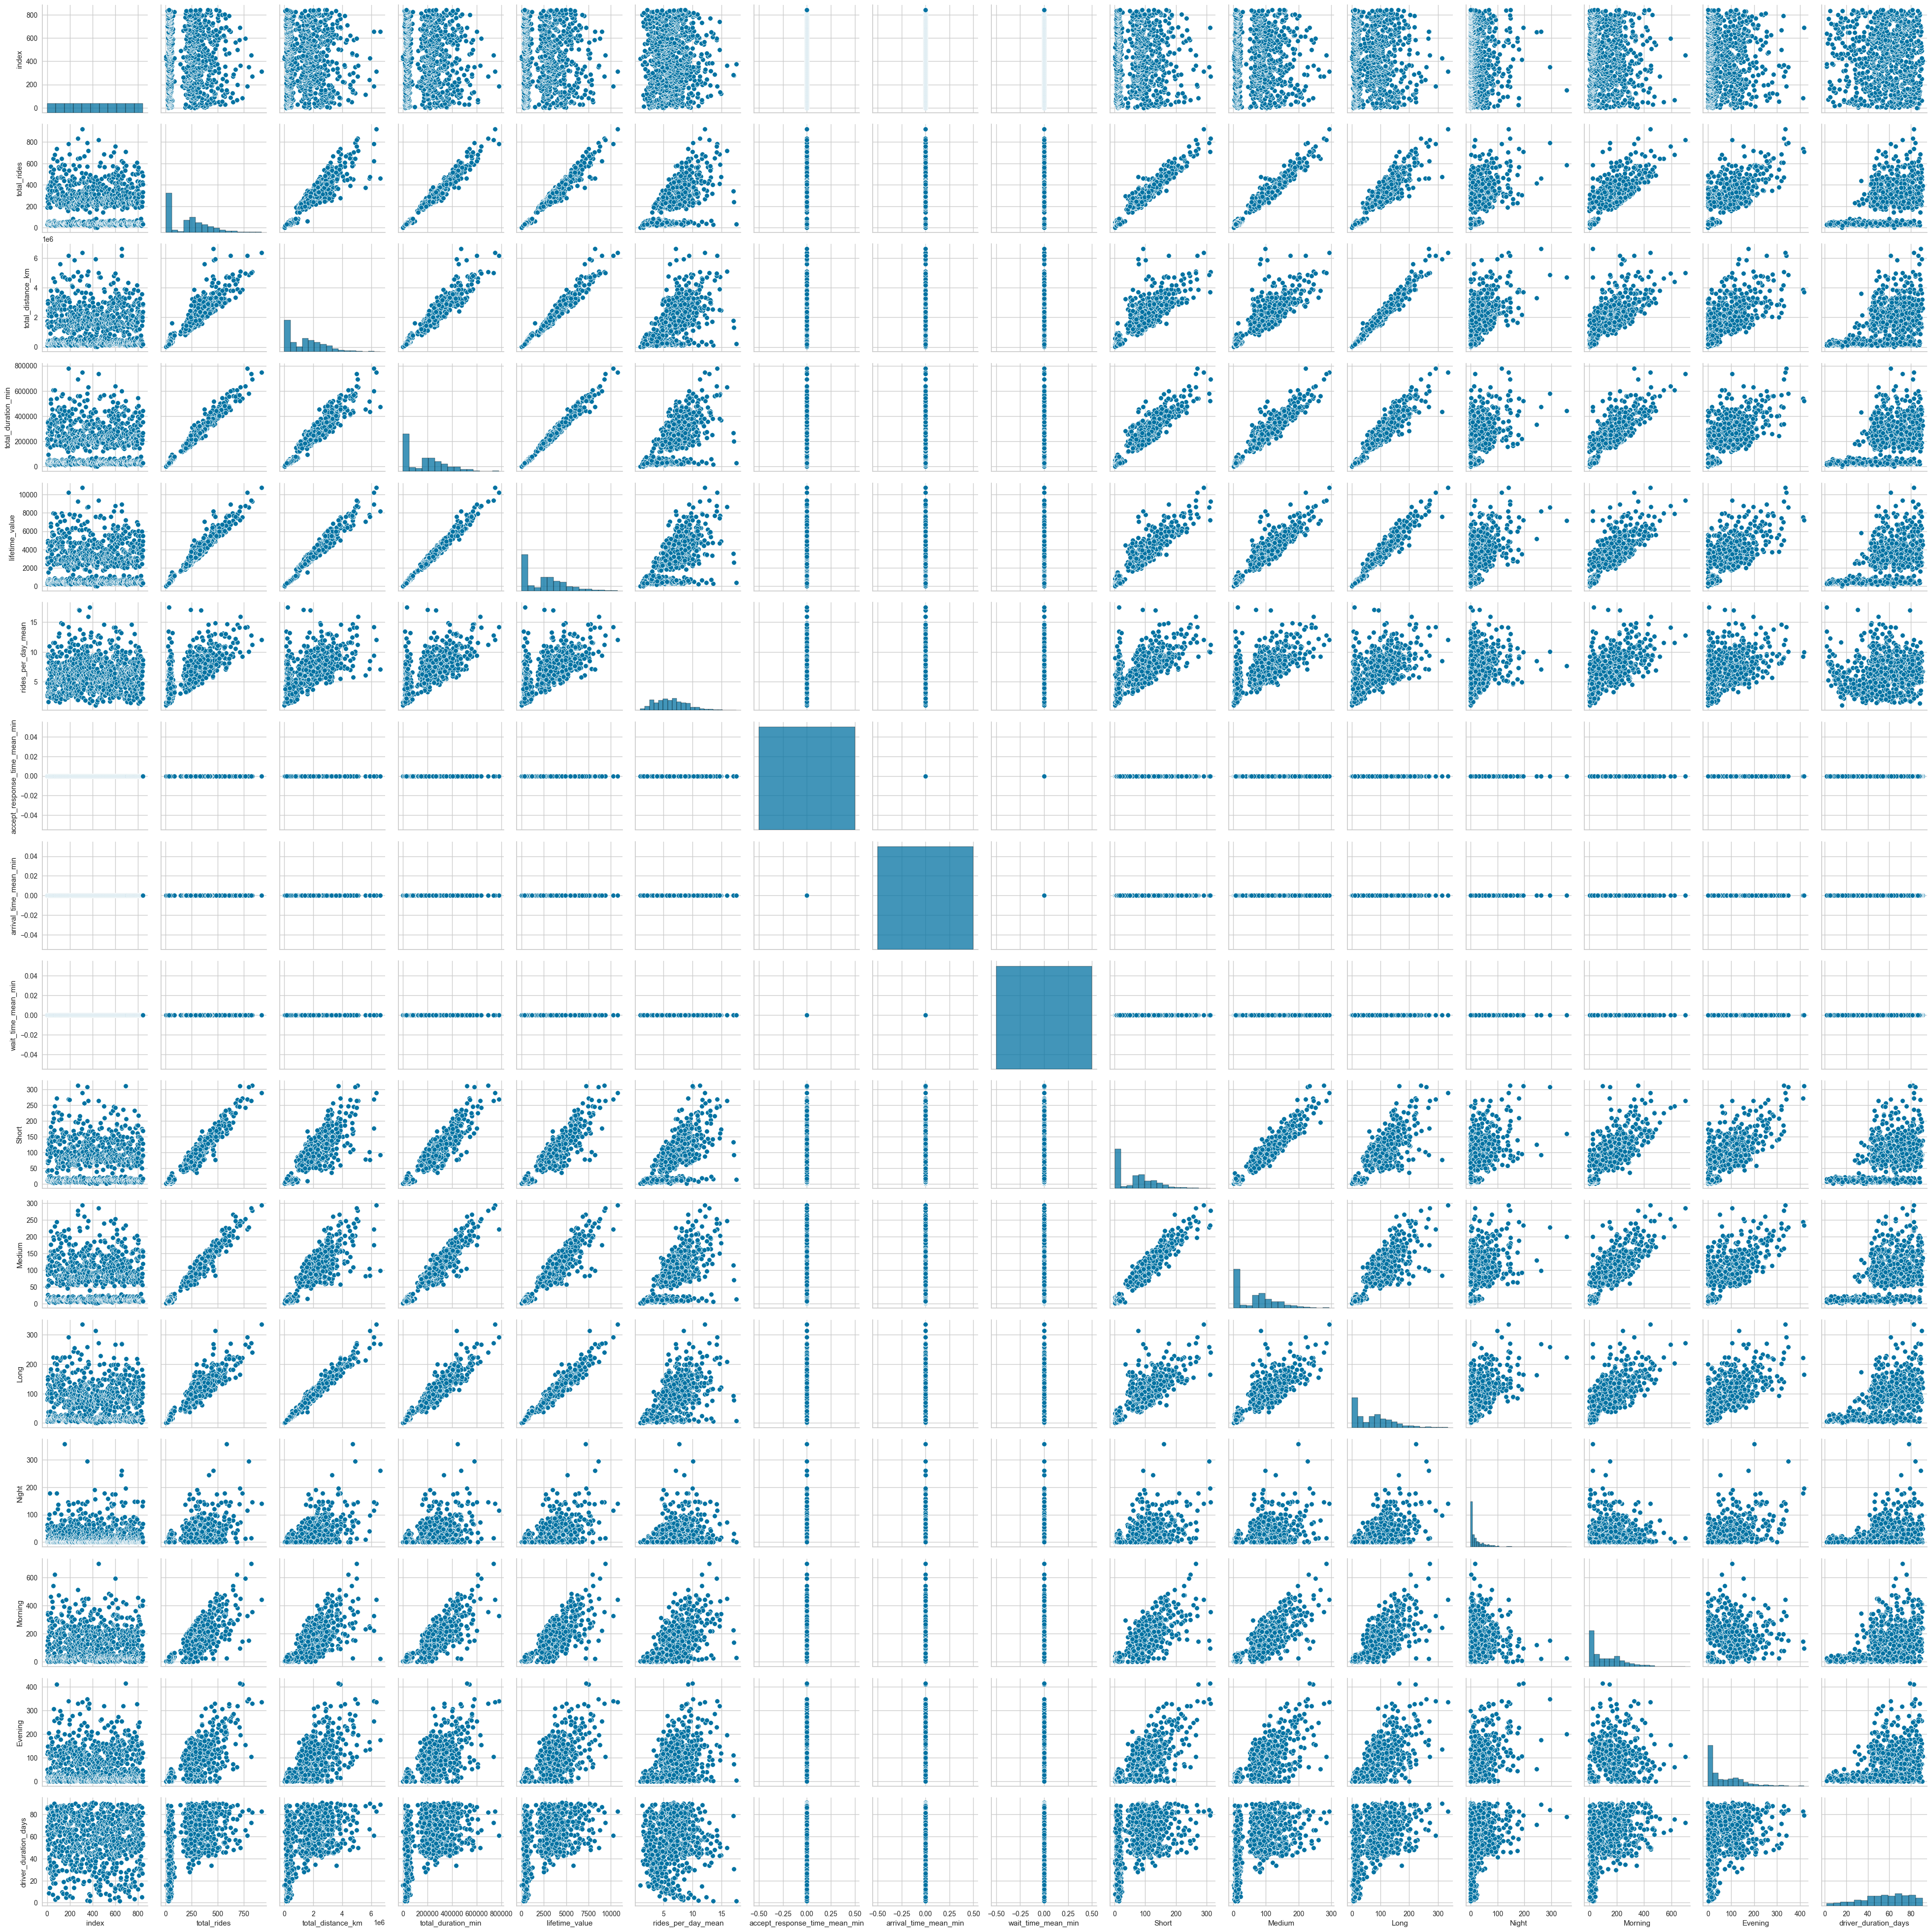

In [79]:

# Scatter plots of data
sns.pairplot(driver_summary)
plt.show()

Generating a heatmap of the correlation matrix for the features within the driver_summary DataFrame. The heatmap visualizes the strength and direction of linear relationships between different attributes. Darker colors indicate stronger correlations, with positive correlations shown in one color spectrum and negative correlations in another. This visualization provides insights into which features are closely related and helps identify potential multicollinearity or patterns in the dataset. Understanding these correlations is crucial for building accurate predictive models and gaining a deeper understanding of the Lyft driver data.







<a name="main-factors-affecting-a-driver's=lifetime-value"></a>
# Main Factors Affecting a Driver's Lifetime Value

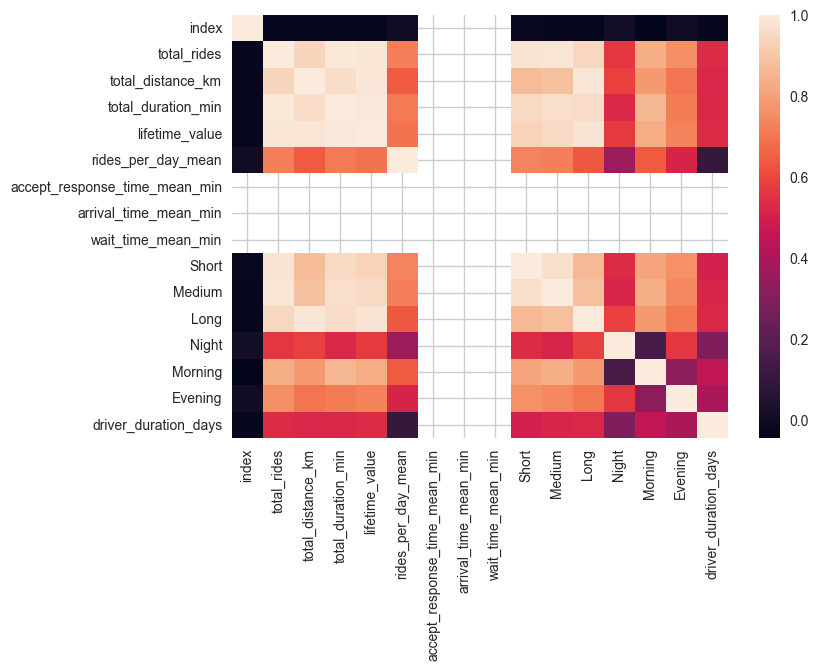

In [80]:

# Plot a heatmap of correlations between features
sns.heatmap(driver_summary.corr())
plt.show()

Calculating the correlation between the lifetime_value column and all other columns in the driver_summary DataFrame. The resulting correlations are stored in a DataFrame called correlation_with_lifetime and sorted in descending order based on the correlation with lifetime_value. The purpose is to identify which features have the highest and lowest correlations with the target variable (lifetime_value). Understanding these correlations helps in determining the factors that significantly influence the lifetime value of Lyft drivers.

In [81]:
# Get a correlation with lifetime_value as a DataFrame sorted in descending order
correlation_with_lifetime = pd.DataFrame(driver_summary.corr()['lifetime_value']).sort_values(by='lifetime_value',
                                                                                             ascending=False)
print(correlation_with_lifetime)

                               lifetime_value
lifetime_value                       1.000000
total_duration_min                   0.993298
total_rides                          0.985404
total_distance_km                    0.984540
Long                                 0.978730
Medium                               0.948202
Short                                0.934289
Morning                              0.829956
Evening                              0.728995
rides_per_day_mean                   0.691232
Night                                0.567500
driver_duration_days                 0.531612
index                               -0.031156
accept_response_time_mean_min             NaN
arrival_time_mean_min                     NaN
wait_time_mean_min                        NaN


 Generating a histogram to visualize the distribution of the driver_duration_days variable in the driver_summary DataFrame. The x-axis represents the duration of stay with Lyft in days, and the y-axis represents the number of drivers falling into each bin. This histogram provides insights into the typical duration of how long drivers continue driving with Lyft, helping to understand the retention patterns of Lyft drivers.

<a name="average-projected-lifetime-of-a-driver"></a>
# Average Projected Lifetime of a Driver

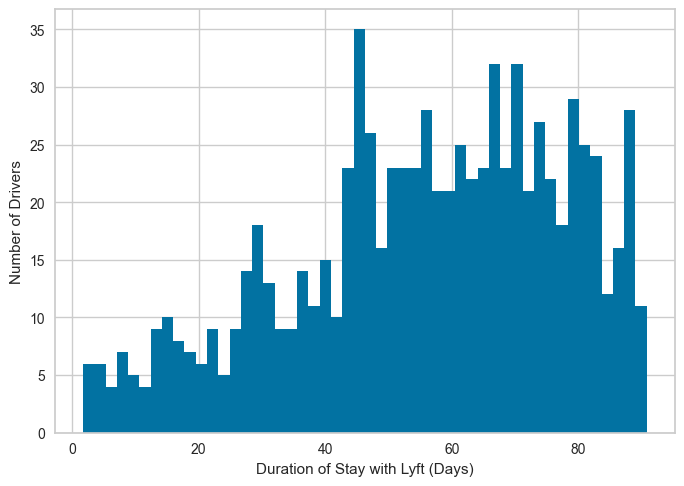

In [82]:
driver_summary['driver_duration_days'].plot.hist(bins=50)
plt.xlabel('Duration of Stay with Lyft (Days)')
plt.ylabel('Number of Drivers')
plt.show()

<a name="business-problem-statement"></a>
# Do All Drivers Act Alike?

Performing clustering analysis using the KMeans algorithm to group Lyft drivers based on their summary features. Here's a breakdown of the code:

**Import Libraries:**

    from sklearn.cluster import KMeans: Import the KMeans clustering algorithm from scikit-learn.

    from yellowbrick.cluster import KElbowVisualizer: Import the KElbowVisualizer from Yellowbrick for visualizing the optimal number of clusters.

**import warnings:** 
    Import warnings to handle any warning messages.

**Ignore Warnings:**

    warnings.filterwarnings('ignore'): Suppress warning messages to maintain clean output.

**Use KElbowVisualizer:**

    Create a KMeans model with model = KMeans(random_state=42).

    Create a KElbowVisualizer with visualizer = KElbowVisualizer(model, k=(2, 12)).

    Fit the visualizer on the data and display the plot with visualizer.show() to determine the optimal number of clusters.

**Fit KMeans Model:**

    Create a KMeans model with the optimal number of clusters obtained from the elbow method: kmeans = KMeans(n_clusters=visualizer.elbow_value_, random_state=42).

    Fit the model on the driver_summary data excluding the 'driver_id' column: kmeans.fit(driver_summary.drop(['driver_id'], axis=1)).

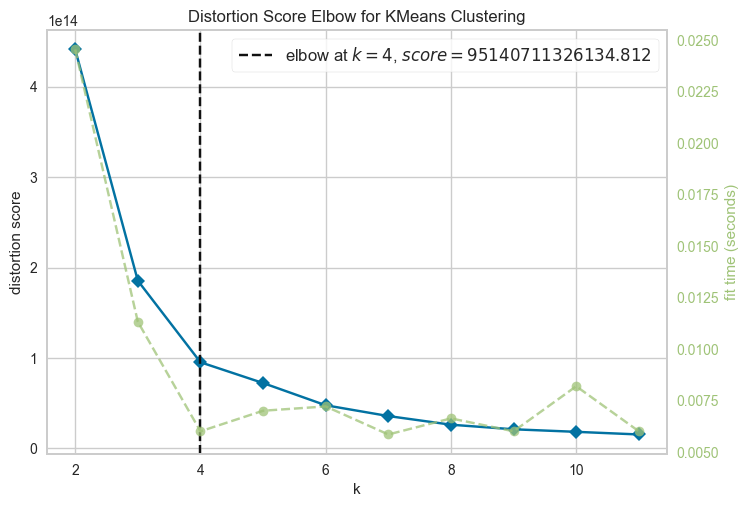

KMeans(n_clusters=4, random_state=42)

In [83]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Use the KElbowVisualizer to determine the optimal number of clusters
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 12))
visualizer.fit(driver_summary.drop(['driver_id'], axis=1))
visualizer.show()

# Fit a K Means model with the optimal number of clusters
kmeans = KMeans(n_clusters=visualizer.elbow_value_, random_state=42)
kmeans.fit(driver_summary.drop(['driver_id'], axis=1))

 Performing a comprehensive exploratory data analysis (EDA) on a dataset related to ride-sharing services. It initially imports necessary libraries and reads three datasets containing information on drivers, ride timestamps, and ride IDs. The code calculates various metrics, such as the total cost of a ride, and transforms the data by pivoting and merging to derive meaningful features. It further categorizes rides into different lengths and times of the day. The EDA includes the creation of a histogram illustrating the distribution of ride length categories. Subsequently, the code analyzes driver-level metrics, calculating total rides, distances, durations, and lifetime values. Clustering analysis is then employed to group drivers based on their performance metrics, and the results are visualized through histograms. Finally, correlation and pair plots provide insights into the relationships between different features, offering a holistic understanding of the ride-sharing dataset.

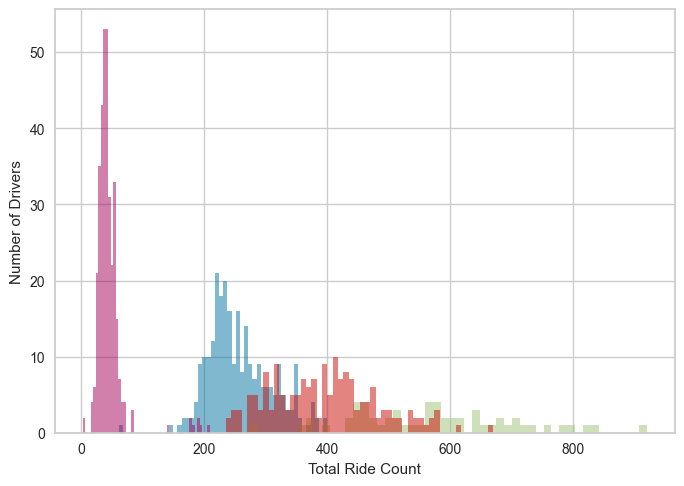

In [84]:
# Add the cluster labels to the dataframe
driver_summary['cluster'] = kmeans.labels_

# Plot the distribution of total ride count by cluster
driver_summary.groupby('cluster')['total_rides'].plot.hist(bins=50, alpha=0.5)
plt.xlabel('Total Ride Count')
plt.ylabel('Number of Drivers')
plt.show()

Extending the exploratory data analysis (EDA) by visualizing the distribution of total lifetime earnings of drivers across different clusters. Utilizing the previously assigned clusters through k-means clustering, the code generates a histogram depicting the spread of lifetime earnings within each cluster. This visualization allows for a comparison of earnings patterns among different driver groups. The x-axis represents total lifetime earnings, and the y-axis indicates the number of drivers in each cluster. This analysis provides valuable insights into the earnings distribution and helps identify patterns or disparities among driver clusters, aiding in a more nuanced understanding of the dataset.







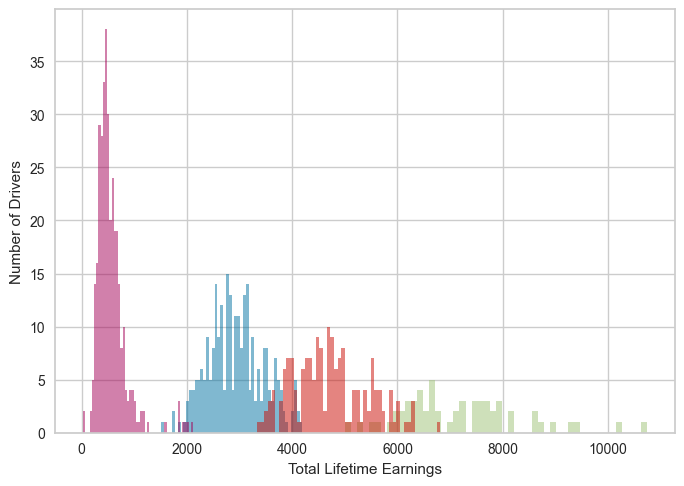

In [85]:
# Plot the distribution of total earnings by cluster
driver_summary.groupby('cluster')['lifetime_value'].plot.hist(bins=50, alpha=0.5)
plt.xlabel('Total Lifetime Earnings')
plt.ylabel('Number of Drivers')
plt.show()

Continuing the exploratory data analysis (EDA) by visualizing the distribution of total ride duration across different clusters of drivers. Similar to previous visualizations, the k-means clustering results are utilized to categorize drivers into distinct groups. The code then generates a histogram, illustrating the spread of total ride duration within each cluster. The x-axis represents the total duration in minutes, while the y-axis indicates the number of drivers in each cluster. This visual representation facilitates a comparative analysis of ride duration patterns among different driver groups, contributing to a comprehensive understanding of the dataset and potentially revealing insights into driving behaviors across various clusters.

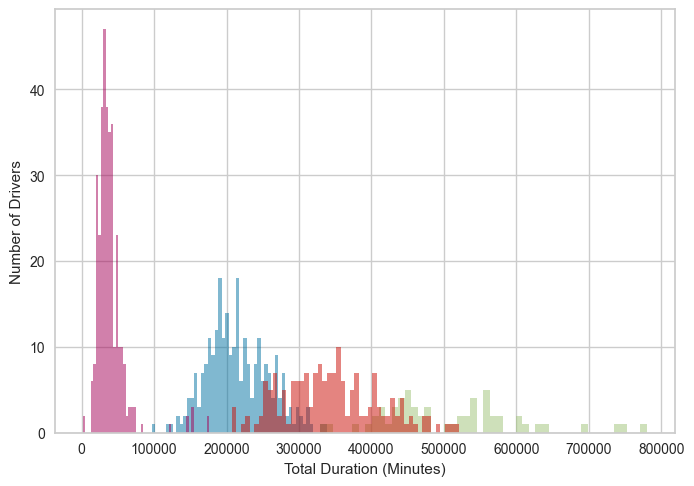

In [86]:

# Plot the distribution of total duration by cluster
driver_summary.groupby('cluster')['total_duration_min'].plot.hist(bins=50, alpha=0.5)
plt.xlabel('Total Duration (Minutes)')
plt.ylabel('Number of Drivers')
plt.show()

Generating a visualization to explore the distribution of total travel distance among different clusters of drivers. Building on the k-means clustering results, which group drivers based on certain characteristics, this visualization employs a histogram to display the spread of total travel distance for each cluster. The x-axis represents the total distance traveled by drivers in kilometers, while the y-axis indicates the count of drivers in each cluster. By examining this distribution, one can gain insights into how different clusters of drivers contribute to the overall travel distance and identify potential patterns or variations in driving behaviors across these clusters.

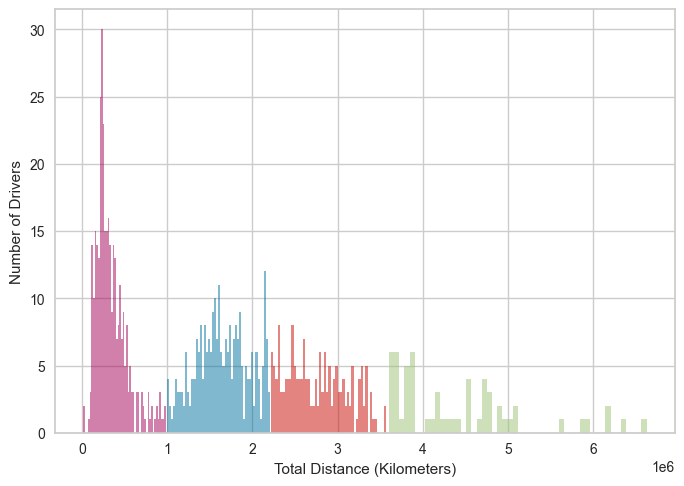

In [87]:
# Plot the distribution of total distance by cluster
driver_summary.groupby('cluster')['total_distance_km'].plot.hist(bins=50, alpha=0.5)
plt.xlabel('Total Distance (Kilometers)')
plt.ylabel('Number of Drivers')
plt.show()

Generating a histogram to illustrate the distribution of a driver's lifetime duration within each cluster. Utilizing the k-means clustering results, which group drivers based on various features, this visualization aims to showcase how the lifetime duration of drivers is distributed across different clusters. The x-axis represents the duration of a driver's lifetime in days, while the y-axis indicates the count of drivers in each cluster. Analyzing this distribution can provide valuable insights into the longevity patterns of drivers within distinct clusters, helping to understand the variations in their overall engagement and commitment to Lyft over time.

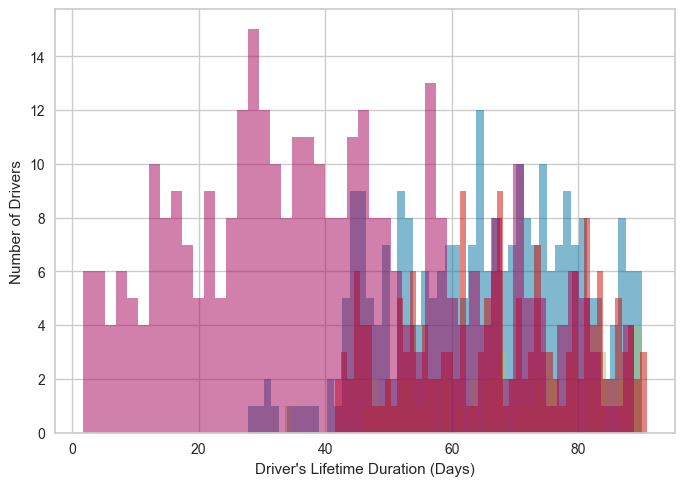

In [88]:
# Plot the distribution of driver's lifetime by cluster
driver_summary.groupby('cluster')['driver_duration_days'].plot.hist(bins=50, alpha=0.5)
plt.xlabel("Driver's Lifetime Duration (Days)")
plt.ylabel('Number of Drivers')
plt.show()

Grouping the driver_summary data based on clusters and calculating the mean values for various features within each cluster. Features such as 'lifetime_value', 'Medium', 'rides_per_day_mean', 'total_duration_min', 'total_distance_km', 'Long', 'Evening', 'Night', 'Morning', 'driver_duration_days', and 'wait_time_mean_min' are included in this aggregation. The resulting grouping_data provides a consolidated view of the average values for these features across different clusters. This analysis helps to identify patterns and trends associated with specific clusters, offering insights into the behaviors and characteristics of drivers within each group.

In [89]:


grouping_data = driver_summary.groupby('cluster')['lifetime_value', 'Medium', 'rides_per_day_mean',
                                                'total_duration_min', 'total_distance_km', 'Long',
                                                'Evening', 'Night', 'Morning',
                                                'driver_duration_days', 'wait_time_mean_min'].agg('mean')

Generating subplots for each column in the 'grouping_data' dataframe, arranging them in a 3x5 grid. It uses the seaborn library to create bar plots for each feature, with the x-axis representing different clusters and the y-axis showing the mean values of the corresponding feature within each cluster. The loop iterates through each column in the dataframe, assigning the appropriate subplot and setting titles, x-axis labels ('Cluster'), and y-axis labels ('Mean [column]'). This visualization allows for a comprehensive comparison of the mean values across different clusters, providing a clear representation of the characteristics associated with each group.

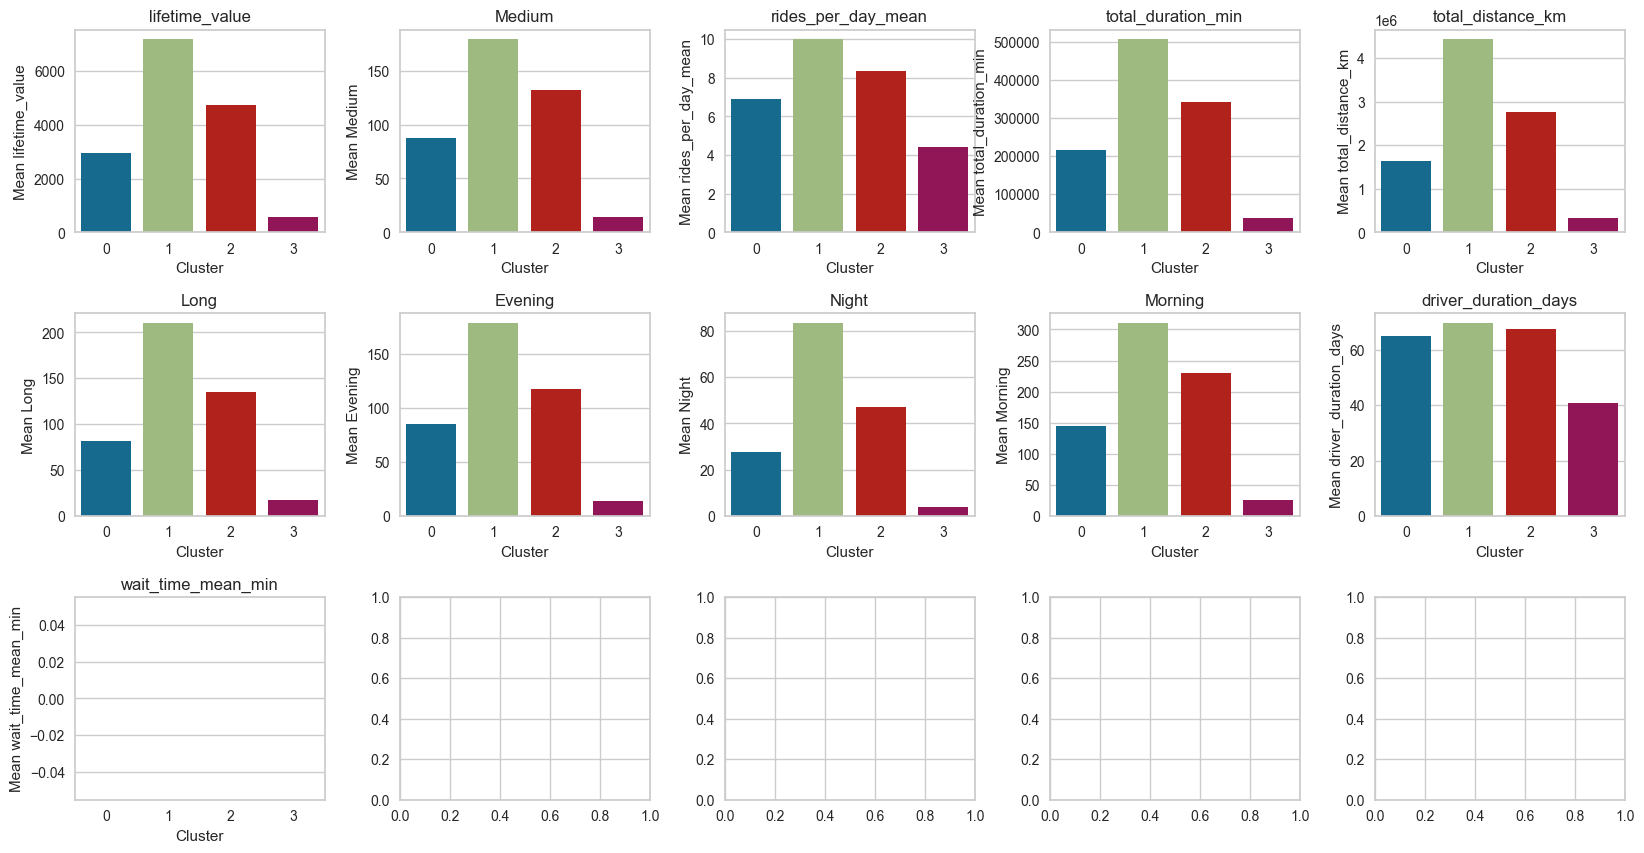

In [90]:

# Create subplots for each column in the grouped dataframe
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Loop through each column in the grouped dataframe and plot it in a subplot
for i, column in enumerate(grouping_data.columns):
    sns.barplot(x=grouping_data.index, y=grouping_data[column], ax=axes[i // 5, i % 5])
    axes[i // 5, i % 5].set_title(column)
    axes[i // 5, i % 5].set_xlabel('Cluster')
    axes[i // 5, i % 5].set_ylabel('Mean ' + column)

plt.show()


<a name="actionable-recommendations"></a>
# Actionable Recommendations :

enhance their overall contribution to the platform. This could involve implementing driver support programs, training sessions, or incentive structures to encourage fair drivers to increase their ride count, reduce wait times, and enhance the overall quality of service.
Identify areas for operational improvements: Analyzing the clusters can help identify specific areas where operational improvements are needed. For instance, if a particular cluster exhibits longer wait times or lower ride counts, operational strategies can be tailored to address these issues and improve overall driver performance and satisfaction.
Implement targeted incentives: The business can implement targeted incentives for drivers in specific clusters to motivate desired behaviors. For example, offering bonuses or rewards for drivers in clusters associated with longer ride distances or higher lifetime values can encourage similar behavior across the platform.
Optimize resource allocation: Understanding driver clusters allows the business to optimize resource allocation. By focusing marketing efforts, promotions, and support programs on clusters with growth potential or improvement needs, the business can efficiently allocate resources to areas where they are likely to have the greatest impact.
Continuously monitor and adapt: The clustering analysis should be part of an ongoing monitoring and improvement process. Regularly reassessing driver clusters and adjusting strategies based on evolving patterns and business goals ensures a dynamic and responsive approach to driver management. This iterative process will contribute to the sustained growth and success of the platform.





